In [1]:
import requests
import pandas as pd
import yfinance as yf
import time
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
import pandas as pd
import re
import pandas as pd
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
import numpy as np

In [2]:
api_key = "Tar1vB6RJGhcZflwTq2RS4hxeBZIcLFC"
url = 'https://api.nytimes.com/svc/archive/v1/{}/{}.json?api-key={}'
stocks = ["apple", "microsoft", "amazon"]
data = []
date = []
stock_list = []

# Create a session with retry strategy
session = requests.Session()
retry_strategy = Retry(
    total=5,
    backoff_factor=10,
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount("https://", adapter)
session.mount("http://", adapter)

a=0
for stock in stocks:
    for year in range(2017, 2025):
        for month in range(1, 13):
            print(a)
            a=a+1
            if(month==6 and year==2024):
                break
            try:
                response = session.get(url.format(year, month, api_key))
                response.raise_for_status()
                data_json = response.json()
                articles = data_json['response']['docs']
                sto_article = []
                for article in articles:
                    headline = article.get('headline', {}).get('main', '').lower()
                    snippet = article.get('snippet', '').lower()
                    if stock in headline or stock in snippet:
                        sto_article.append(article)

                for article in sto_article:
                    stock_list.append(stock.upper())
                    headline = article['headline']['main']
                    date_time = article['pub_date']
                    date_only = pd.to_datetime(date_time).date()
                    data.append(headline)
                    date.append(date_only)


                time.sleep(12)

            except:
                print("ERROR")


df = pd.DataFrame({
    'Date': date,
    'Stock': stock_list,
    'Headline': data
})

print("end")
print(df.head())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
end
         Date  Stock      

In [3]:
def clean_text(text):
    # Remove all non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower()

final_df=df.groupby(["Date","Stock"])["Headline"].apply(lambda x: " ".join(x.astype(str))).reset_index()
final_df["Headline"]=final_df["Headline"].apply(clean_text)

print(final_df.head(10))

         Date      Stock                                           Headline
0  2017-01-02     AMAZON  riot by drug gangs in brazil prison leaves at ...
1  2017-01-02      APPLE  growing a different apple joyce appleby histor...
2  2017-01-02  MICROSOFT    where to go if you forget your hotmail password
3  2017-01-03      APPLE  daily report an exapple employee firm far from...
4  2017-01-04      APPLE  adding colors to mac folders apple removes new...
5  2017-01-05     AMAZON  amazon to open retail store in manhattan at ti...
6  2017-01-05      APPLE  bringing icloud files down to earth daily repo...
7  2017-01-06     AMAZON  daily report the next voice you hear will be a...
8  2017-01-07      APPLE  russia requires apple and google to remove lin...
9  2017-01-09      APPLE  trumps industry criticisms shift detroit auto ...


In [4]:
from textblob import TextBlob as tb

final_df['Polarity_score']=float(0)
final_df['Subjectivity_score']=float(0)

for i in range(0,len(final_df['Headline'])):
    score=tb(final_df['Headline'][i])
    final_df.at[i,'Polarity_score']=float(score.sentiment[0])
    final_df.at[i,'Subjectivity_score']=float(score.sentiment[1])



print(final_df.head())

         Date      Stock                                           Headline  \
0  2017-01-02     AMAZON  riot by drug gangs in brazil prison leaves at ...   
1  2017-01-02      APPLE  growing a different apple joyce appleby histor...   
2  2017-01-02  MICROSOFT    where to go if you forget your hotmail password   
3  2017-01-03      APPLE  daily report an exapple employee firm far from...   
4  2017-01-04      APPLE  adding colors to mac folders apple removes new...   

   Polarity_score  Subjectivity_score  
0       -0.250000            0.400000  
1       -0.066667            0.333333  
2        0.000000            0.000000  
3       -0.033333            0.466667  
4        0.136364            0.454545  


In [5]:

final_df["Price Movement"]=-1
final_df['Open']=-1
final_df['Close']=-1


for i in range(0,len(final_df['Date'])):
    ticker=''
    if(final_df['Stock'][i]=='APPLE'):
        ticker='AAPL'
    elif(final_df['Stock'][i]=='MICROSOFT'):
        ticker='MSFT'
    else:
        ticker="AMZN"

    date=final_df['Date'][i]
    try:
        data = yf.download(ticker, start=date, end=pd.to_datetime(date) + pd.DateOffset(1))
    except:
       continue


    if not data.empty:
        if(data.iloc[0]['Open']<data.iloc[0]['Close']):
            final_df.at[i,'Price Movement']=1

        else:
            final_df.at[i,'Price Movement']=0
        final_df.at[i,'Open']=data.iloc[0]['Open']
        final_df.at[i,'Close']=data.iloc[0]['Close']

final_df=final_df[final_df['Price Movement']!=-1]


print(final_df.head())



[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-01-02 -> 2017-01-03 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2017-01-02 -> 2017-01-03 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-01-02 -> 2017-01-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-01-02 -> 2017-01-03 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2017-01-02 -> 2017-01-03 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2017-01-02 -> 2017-01-03 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-01-07 -> 2017-01-08 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2017-01-07 -> 2017-01-08 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-01-14 -> 2017-01-15 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-01-16 -> 2017-01-17 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed downl

$AAPL: possibly delisted; No price data found  (1d 2017-01-14 -> 2017-01-15 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2017-01-16 -> 2017-01-17 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-01-16 -> 2017-01-17 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-01-21 -> 2017-01-22 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-01-22 -> 2017-01-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2017-01-21 -> 2017-01-22 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-01-22 -> 2017-01-23 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly 

$AAPL: possibly delisted; No price data found  (1d 2017-02-04 -> 2017-02-05 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-02-20 -> 2017-02-21 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-02-20 -> 2017-02-21 00:00:00)')
[*********************100%%****

$AMZN: possibly delisted; No price data found  (1d 2017-02-20 -> 2017-02-21 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-02-20 -> 2017-02-21 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2017-02-20 -> 2017-02-21 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-02-25 -> 2017-02-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2017-02-25 -> 2017-02-26 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-03-05 -> 2017-03-06 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2017-03-05 -> 2017-03-06 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-03-12 -> 2017-03-13 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-03-12 -> 2017-03-13 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2017-03-12 -> 2017-03-13 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2017-03-12 -> 2017-03-13 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-03-25 -> 2017-03-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2017-03-25 -> 2017-03-26 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-04-01 -> 2017-04-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: possibly delisted; No price data found  (1d 2017-04-02 -> 2017-04-03 00:00:00)
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-04-02 -> 2017-04-03 00:00:00)')


$MSFT: possibly delisted; No price data found  (1d 2017-04-01 -> 2017-04-02 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-04-02 -> 2017-04-03 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-04-14 -> 2017-04-15 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 complete

$AMZN: possibly delisted; No price data found  (1d 2017-04-14 -> 2017-04-15 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2017-04-16 -> 2017-04-17 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-04-14 -> 2017-04-15 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-04-23 -> 2017-04-24 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2017-04-23 -> 2017-04-24 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-04-30 -> 2017-05-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-04-30 -> 2017-05-01 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2017-04-30 -> 2017-05-01 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-04-30 -> 2017-05-01 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AAPL: possibly delisted; No price data found  (1d 2017-05-13 -> 2017-05-14 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-05-27 -> 2017-05-28 00:00:00)')
[*********************100%%**********************]  1 of 1 complet

$AMZN: possibly delisted; No price data found  (1d 2017-05-27 -> 2017-05-28 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-05-28 -> 2017-05-29 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-05-29 -> 2017-05-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2017-05-29 -> 2017-05-30 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-06-03 -> 2017-06-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2017-06-03 -> 2017-06-04 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-06-10 -> 2017-06-11 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-06-11 -> 2017-06-12 00:00:00)')
[*********************100%%***

$AAPL: possibly delisted; No price data found  (1d 2017-06-10 -> 2017-06-11 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2017-06-11 -> 2017-06-12 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-06-17 -> 2017-06-18 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-06-17 -> 2017-06-18 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2017-06-17 -> 2017-06-18 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-06-17 -> 2017-06-18 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-06-25 -> 2017-06-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2017-06-25 -> 2017-06-26 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-07-04 -> 2017-07-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2017-07-04 -> 2017-07-05 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-07-08 -> 2017-07-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-07-09 -> 2017-07-10 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2017-07-08 -> 2017-07-09 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-07-09 -> 2017-07-10 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-07-16 -> 2017-07-17 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2017-07-16 -> 2017-07-17 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-07-22 -> 2017-07-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-07-23 -> 2017-07-24 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2017-07-22 -> 2017-07-23 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2017-07-23 -> 2017-07-24 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-07-23 -> 2017-07-24 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2017-07-23 -> 2017-07-24 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-07-29 -> 2017-07-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: possib

$AAPL: possibly delisted; No price data found  (1d 2017-07-29 -> 2017-07-30 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-07-30 -> 2017-07-31 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AAPL: possibly delisted; No price data found  (1d 2017-08-12 -> 2017-08-13 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-08-19 -> 2017-08-20 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-08-20 -> 2017-08-21 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2017-08-19 -> 2017-08-20 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-08-20 -> 2017-08-21 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2017-08-20 -> 2017-08-21 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-08-20 -> 2017-08-21 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPrice

$AMZN: possibly delisted; No price data found  (1d 2017-08-27 -> 2017-08-28 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-09-03 -> 2017-09-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2017-09-03 -> 2017-09-04 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-09-09 -> 2017-09-10 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-09-10 -> 2017-09-11 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-09-10 -> 2017-09-11 00:00:

$AMZN: possibly delisted; No price data found  (1d 2017-09-09 -> 2017-09-10 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2017-09-10 -> 2017-09-11 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-09-10 -> 2017-09-11 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-09-16 -> 2017-09-17 00:00:00)')
[*********************100%%**********************]  1 of 1 complete

$AMZN: possibly delisted; No price data found  (1d 2017-09-16 -> 2017-09-17 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2017-09-17 -> 2017-09-18 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-09-17 -> 2017-09-18 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-09-23 -> 2017-09-24 00:00:00)')
[*********************100%%**********************]  1 of 1 complete

$AMZN: possibly delisted; No price data found  (1d 2017-09-23 -> 2017-09-24 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-09-30 -> 2017-10-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-10-01 -> 2017-10-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2017-09-30 -> 2017-10-01 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2017-10-01 -> 2017-10-02 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-10-07 -> 2017-10-08 00:00:00)'

$AAPL: possibly delisted; No price data found  (1d 2017-10-07 -> 2017-10-08 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-10-08 -> 2017-10-09 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-10-15 -> 2017-10-16 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 complet

$AMZN: possibly delisted; No price data found  (1d 2017-10-15 -> 2017-10-16 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-10-22 -> 2017-10-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2017-10-22 -> 2017-10-23 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-10-28 -> 2017-10-29 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2017-10-28 -> 2017-10-29 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AMZN: possibly delisted; No price data found  (1d 2017-11-11 -> 2017-11-12 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2017-11-12 -> 2017-11-13 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-11-25 -> 2017-11-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1

$AMZN: possibly delisted; No price data found  (1d 2017-11-25 -> 2017-11-26 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2017-11-26 -> 2017-11-27 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2017-12-03 -> 2017-12-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2017-12-03 -> 2017-12-04 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AMZN: possibly delisted; No price data found  (1d 2017-12-30 -> 2017-12-31 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-01-01 -> 2018-01-02 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-01-15 -> 2018-01-16 00:00:00)'

$AAPL: possibly delisted; No price data found  (1d 2018-01-15 -> 2018-01-16 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-01-20 -> 2018-01-21 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-01-21 -> 2018-01-22 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2018-01-20 -> 2018-01-21 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-01-21 -> 2018-01-22 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-01-27 -> 2018-01-28 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d

$AMZN: possibly delisted; No price data found  (1d 2018-01-27 -> 2018-01-28 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-01-27 -> 2018-01-28 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-01-28 -> 2018-01-29 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-02-03 -> 2018-02-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPrice

$AMZN: possibly delisted; No price data found  (1d 2018-02-03 -> 2018-02-04 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-02-04 -> 2018-02-05 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AAPL: possibly delisted; No price data found  (1d 2018-02-17 -> 2018-02-18 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-02-18 -> 2018-02-19 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-02-25 -> 2018-02-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-02-25 -> 2018-02-26 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2018-02-25 -> 2018-02-26 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-02-25 -> 2018-02-26 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-03-10 -> 2018-03-11 00:00:00)'

$AMZN: possibly delisted; No price data found  (1d 2018-03-10 -> 2018-03-11 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: possibly delisted; No price data found  (1d 2018-03-18 -> 2018-03-19 00:00:00)
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-03-18 -> 2018-03-19 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2018-03-18 -> 2018-03-19 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-03-25 -> 2018-03-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-03-25 -> 2018-03-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2018-03-25 -> 2018-03-26 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-03-25 -> 2018-03-26 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-03-30 -> 2018-03-31 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-03-31 -> 2018-04-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-04-01 -> 2018-04-02 00:00:

$AMZN: possibly delisted; No price data found  (1d 2018-03-30 -> 2018-03-31 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-03-31 -> 2018-04-01 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-04-01 -> 2018-04-02 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-04-01 -> 2018-04-02 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: possibly delisted; No price data found  (1d 2018-04-22 -> 2018-04-23 00:00:00)
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AMZN: possibly delisted; No price data found  (1d 2018-04-22 -> 2018-04-23 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-04-29 -> 2018-04-30 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2018-04-29 -> 2018-04-30 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-04-28 -> 2018-04-29 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-04-29 -> 2018-04-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2018-04-29 -> 2018-04-30 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-05-05 -> 2018-05-06 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-05-06 -> 2018-05-07 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2018-05-05 -> 2018-05-06 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2018-05-06 -> 2018-05-07 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AAPL: possibly delisted; No price data found  (1d 2018-05-28 -> 2018-05-29 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-06-02 -> 2018-06-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-06-03 -> 2018-06-04 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2018-06-02 -> 2018-06-03 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-06-03 -> 2018-06-04 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-06-10 -> 2018-06-11 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2018-06-10 -> 2018-06-11 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-06-16 -> 2018-06-17 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-06-17 -> 2018-06-18 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2018-06-16 -> 2018-06-17 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-06-17 -> 2018-06-18 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-06-23 -> 2018-06-24 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2018-06-23 -> 2018-06-24 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-07-01 -> 2018-07-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2018-07-01 -> 2018-07-02 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-07-04 -> 2018-07-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2018-07-04 -> 2018-07-05 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-07-08 -> 2018-07-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2018-07-08 -> 2018-07-09 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-07-14 -> 2018-07-15 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-07-15 -> 2018-07-16 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2018-07-14 -> 2018-07-15 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-07-15 -> 2018-07-16 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-07-21 -> 2018-07-22 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-07-22 -> 2018-07-23 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2018-07-21 -> 2018-07-22 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-07-22 -> 2018-07-23 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-07-29 -> 2018-07-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2018-07-29 -> 2018-07-30 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-08-04 -> 2018-08-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1

$AAPL: possibly delisted; No price data found  (1d 2018-08-04 -> 2018-08-05 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-08-05 -> 2018-08-06 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-08-05 -> 2018-08-06 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: possibly delisted; No price data found  (1d 2018-08-19 -> 2018-08-20 00:00:00)
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$MSFT: possibly delisted; No price data found  (1d 2018-08-19 -> 2018-08-20 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-08-25 -> 2018-08-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2018-08-25 -> 2018-08-26 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-09-01 -> 2018-09-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-09-03 -> 2018-09-04 00:00:00)')
[*********************100%%****

$AMZN: possibly delisted; No price data found  (1d 2018-09-01 -> 2018-09-02 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-09-03 -> 2018-09-04 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-09-08 -> 2018-09-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL', 'MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-09-09 -> 2018-09-10 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2018-09-08 -> 2018-09-09 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-09-09 -> 2018-09-10 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2018-09-09 -> 2018-09-10 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-09-16 -> 2018-09-17 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2018-09-16 -> 2018-09-17 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-09-22 -> 2018-09-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d

$AMZN: possibly delisted; No price data found  (1d 2018-09-22 -> 2018-09-23 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-09-23 -> 2018-09-24 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly 

$AMZN: possibly delisted; No price data found  (1d 2018-10-06 -> 2018-10-07 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-10-13 -> 2018-10-14 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-10-14 -> 2018-10-15 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2018-10-13 -> 2018-10-14 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-10-14 -> 2018-10-15 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-10-20 -> 2018-10-21 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-10-21 -> 2018-10-22 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed downl

$AMZN: possibly delisted; No price data found  (1d 2018-10-20 -> 2018-10-21 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-10-21 -> 2018-10-22 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-10-21 -> 2018-10-22 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AMZN: possibly delisted; No price data found  (1d 2018-11-04 -> 2018-11-05 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-11-10 -> 2018-11-11 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d

$AMZN: possibly delisted; No price data found  (1d 2018-11-10 -> 2018-11-11 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-11-10 -> 2018-11-11 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-11-11 -> 2018-11-12 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-11-17 -> 2018-11-18 00:00:00)')
[*********************100%%**********************]  1 of 1 complete

$AMZN: possibly delisted; No price data found  (1d 2018-11-17 -> 2018-11-18 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-11-18 -> 2018-11-19 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-11-22 -> 2018-11-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: possibly delisted; No price data found  (1d 2018-11-22 -> 2018-11-23 00:00:00)
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-11-22 -> 2018-11-23 00:00:00)')
[*********************100%%**

$AMZN: possibly delisted; No price data found  (1d 2018-11-22 -> 2018-11-23 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-11-22 -> 2018-11-23 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-12-01 -> 2018-12-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-12-01 -> 2018-12-02 00:00:00)')
[*********************100%%***

$AMZN: possibly delisted; No price data found  (1d 2018-12-01 -> 2018-12-02 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-12-01 -> 2018-12-02 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-12-02 -> 2018-12-03 00:00:00)



[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-12-05 -> 2018-12-06 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-12-08 -> 2018-12-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2018-12-05 -> 2018-12-06 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-12-08 -> 2018-12-09 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-12-15 -> 2018-12-16 00:00:00)')
[*********************100%%**********************]  1 of 1 complete

$AMZN: possibly delisted; No price data found  (1d 2018-12-15 -> 2018-12-16 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2018-12-16 -> 2018-12-17 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-12-15 -> 2018-12-16 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2018-12-16 -> 2018-12-17 00:00:00)


ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-12-16 -> 2018-12-17 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-12-25 -> 2018-12-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 complet

$AAPL: possibly delisted; No price data found  (1d 2018-12-25 -> 2018-12-26 00:00:00)



[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-01 -> 2019-01-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2019-01-01 -> 2019-01-02 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-05 -> 2019-01-06 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-05 -> 2019-01-06 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-06 -> 2019-01-07 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2019-01-05 -> 2019-01-06 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-01-05 -> 2019-01-06 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-01-06 -> 2019-01-07 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-12 -> 2019-01-13 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-13 -> 2019-01-14 00:00:00)')
[*********************100%%****

$AMZN: possibly delisted; No price data found  (1d 2019-01-12 -> 2019-01-13 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-01-13 -> 2019-01-14 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-19 -> 2019-01-20 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-19 -> 2019-01-20 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-20 -> 2019-01-21 00:00:

$AMZN: possibly delisted; No price data found  (1d 2019-01-19 -> 2019-01-20 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2019-01-19 -> 2019-01-20 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-01-20 -> 2019-01-21 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-01-26 -> 2019-01-27 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2019-01-26 -> 2019-01-27 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-02-02 -> 2019-02-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-02-03 -> 2019-02-04 00:00:00)')
[*********************100%%***

$AMZN: possibly delisted; No price data found  (1d 2019-02-02 -> 2019-02-03 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-02-03 -> 2019-02-04 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AMZN: possibly delisted; No price data found  (1d 2019-02-16 -> 2019-02-17 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-02-18 -> 2019-02-19 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly 

$AMZN: possibly delisted; No price data found  (1d 2019-03-02 -> 2019-03-03 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-03-03 -> 2019-03-04 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-03-03 -> 2019-03-04 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-03-09 -> 2019-03-10 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-03-09 -> 2019-03-10 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2019-03-09 -> 2019-03-10 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-03-09 -> 2019-03-10 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-03-16 -> 2019-03-17 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-03-16 -> 2019-03-17 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2019-03-16 -> 2019-03-17 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-03-16 -> 2019-03-17 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-03-17 -> 2019-03-18 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2019-03-17 -> 2019-03-18 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download

$AAPL: possibly delisted; No price data found  (1d 2019-03-30 -> 2019-03-31 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-03-31 -> 2019-04-01 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-04-06 -> 2019-04-07 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2019-04-06 -> 2019-04-07 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-04-13 -> 2019-04-14 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-04-13 -> 2019-04-14 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2019-04-13 -> 2019-04-14 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-04-13 -> 2019-04-14 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-04-19 -> 2019-04-20 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2019-04-19 -> 2019-04-20 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-04-27 -> 2019-04-28 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-04-28 -> 2019-04-29 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2019-04-27 -> 2019-04-28 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-04-28 -> 2019-04-29 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AMZN: possibly delisted; No price data found  (1d 2019-05-18 -> 2019-05-19 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-05-18 -> 2019-05-19 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-05-19 -> 2019-05-20 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2019-05-19 -> 2019-05-20 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-05-27 -> 2019-05-28 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2019-05-27 -> 2019-05-28 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-01 -> 2019-06-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-02 -> 2019-06-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2019-06-01 -> 2019-06-02 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-06-02 -> 2019-06-03 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-08 -> 2019-06-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-08 -> 2019-06-09 00:00:00)')
[*********************100%%***

$AAPL: possibly delisted; No price data found  (1d 2019-06-08 -> 2019-06-09 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2019-06-08 -> 2019-06-09 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-15 -> 2019-06-16 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2019-06-15 -> 2019-06-16 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-22 -> 2019-06-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-23 -> 2019-06-24 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-23 -> 2019-06-24 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2019-06-22 -> 2019-06-23 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-06-23 -> 2019-06-24 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2019-06-23 -> 2019-06-24 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-29 -> 2019-06-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-29 -> 2019-06-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2019-06-29 -> 2019-06-30 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-06-29 -> 2019-06-30 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-06-30 -> 2019-07-01 00:00:00)



ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-30 -> 2019-07-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-06-30 -> 2019-07-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$MSFT: possibly delisted; No price data found  (1d 2019-06-30 -> 2019-07-01 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-07-04 -> 2019-07-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-07-04 -> 2019-07-05 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2019-07-04 -> 2019-07-05 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-07-04 -> 2019-07-05 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-07-13 -> 2019-07-14 00:00:00)')
[*********************100%%**********************]  1 of 1 complete

$AMZN: possibly delisted; No price data found  (1d 2019-07-13 -> 2019-07-14 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly d

$AAPL: possibly delisted; No price data found  (1d 2019-07-27 -> 2019-07-28 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-07-28 -> 2019-07-29 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-08-03 -> 2019-08-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-08-03 -> 2019-08-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-08-04 -> 2019-08-05 00:00:

$AMZN: possibly delisted; No price data found  (1d 2019-08-03 -> 2019-08-04 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-08-03 -> 2019-08-04 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-08-04 -> 2019-08-05 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-08-11 -> 2019-08-12 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2019-08-11 -> 2019-08-12 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-08-24 -> 2019-08-25 00:00:00)')
[*********************100%%**********************]  1 of 1 complet

$AMZN: possibly delisted; No price data found  (1d 2019-08-24 -> 2019-08-25 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-08-24 -> 2019-08-25 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-08-31 -> 2019-09-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-09-01 -> 2019-09-02 00:00:00)')


$MSFT: possibly delisted; No price data found  (1d 2019-08-31 -> 2019-09-01 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-09-01 -> 2019-09-02 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-09-08 -> 2019-09-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-09-08 -> 2019-09-09 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2019-09-08 -> 2019-09-09 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-09-08 -> 2019-09-09 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2019-09-08 -> 2019-09-09 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-09-08 -> 2019-09-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 complete

$MSFT: possibly delisted; No price data found  (1d 2019-09-21 -> 2019-09-22 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-09-28 -> 2019-09-29 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2019-09-28 -> 2019-09-29 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-10-05 -> 2019-10-06 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-10-06 -> 2019-10-07 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possib

$AAPL: possibly delisted; No price data found  (1d 2019-10-05 -> 2019-10-06 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-10-06 -> 2019-10-07 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-10-06 -> 2019-10-07 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AMZN: possibly delisted; No price data found  (1d 2019-10-26 -> 2019-10-27 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-11-02 -> 2019-11-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d

$AMZN: possibly delisted; No price data found  (1d 2019-11-02 -> 2019-11-03 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-11-02 -> 2019-11-03 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-11-10 -> 2019-11-11 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-11-10 -> 2019-11-11 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2019-11-10 -> 2019-11-11 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-11-10 -> 2019-11-11 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-11-17 -> 2019-11-18 00:00:00)')
[*********************100%%**********************]  1 of 1 complete

$AMZN: possibly delisted; No price data found  (1d 2019-11-17 -> 2019-11-18 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-11-23 -> 2019-11-24 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2019-11-23 -> 2019-11-24 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-11-28 -> 2019-11-29 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2019-11-28 -> 2019-11-29 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-11-30 -> 2019-12-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-11-30 -> 2019-12-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-12-01 -> 2019-12-02 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2019-11-30 -> 2019-12-01 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-11-30 -> 2019-12-01 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2019-12-01 -> 2019-12-02 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-12-01 -> 2019-12-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2019-12-01 -> 2019-12-02 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-12-07 -> 2019-12-08 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-12-07 -> 2019-12-08 00:00:00)')
[*********************100%%***

$AMZN: possibly delisted; No price data found  (1d 2019-12-07 -> 2019-12-08 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2019-12-07 -> 2019-12-08 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-12-15 -> 2019-12-16 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-12-15 -> 2019-12-16 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2019-12-15 -> 2019-12-16 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2019-12-15 -> 2019-12-16 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-12-21 -> 2019-12-22 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2019-12-21 -> 2019-12-22 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2019-12-29 -> 2019-12-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2019-12-29 -> 2019-12-30 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-01-05 -> 2020-01-06 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-01-05 -> 2020-01-06 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2020-01-05 -> 2020-01-06 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-01-05 -> 2020-01-06 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AAPL: possibly delisted; No price data found  (1d 2020-01-18 -> 2020-01-19 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2020-01-19 -> 2020-01-20 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-01-19 -> 2020-01-20 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-01-20 -> 2020-01-21 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-01-20 -> 2020-01-21 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2020-01-20 -> 2020-01-21 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-01-20 -> 2020-01-21 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-02-01 -> 2020-02-02 00:00:00)')
[*********************100%%**********************]  1 of 1 complete

$AMZN: possibly delisted; No price data found  (1d 2020-02-01 -> 2020-02-02 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2020-02-02 -> 2020-02-03 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-02-02 -> 2020-02-03 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-02-09 -> 2020-02-10 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2020-02-09 -> 2020-02-10 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-02-16 -> 2020-02-17 00:00:00)')
[*********************100%%**********************]  1 of 1 complet

$AMZN: possibly delisted; No price data found  (1d 2020-02-16 -> 2020-02-17 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-02-17 -> 2020-02-18 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-02-22 -> 2020-02-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-02-23 -> 2020-02-24 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2020-02-22 -> 2020-02-23 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-02-23 -> 2020-02-24 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AMZN: possibly delisted; No price data found  (1d 2020-03-14 -> 2020-03-15 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-03-14 -> 2020-03-15 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2020-03-15 -> 2020-03-16 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-03-21 -> 2020-03-22 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-03-22 -> 2020-03-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibl

$AMZN: possibly delisted; No price data found  (1d 2020-03-21 -> 2020-03-22 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2020-03-22 -> 2020-03-23 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-03-22 -> 2020-03-23 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly d

$AMZN: possibly delisted; No price data found  (1d 2020-04-05 -> 2020-04-06 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2020-04-10 -> 2020-04-11 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-04-10 -> 2020-04-11 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-04-12 -> 2020-04-13 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2020-04-10 -> 2020-04-11 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-04-12 -> 2020-04-13 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-04-18 -> 2020-04-19 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-04-19 -> 2020-04-20 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed downl

$AMZN: possibly delisted; No price data found  (1d 2020-04-18 -> 2020-04-19 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2020-04-19 -> 2020-04-20 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-04-19 -> 2020-04-20 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-04-25 -> 2020-04-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2020-04-25 -> 2020-04-26 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-05-03 -> 2020-05-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2020-05-03 -> 2020-05-04 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-05-09 -> 2020-05-10 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2020-05-09 -> 2020-05-10 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-05-16 -> 2020-05-17 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2020-05-16 -> 2020-05-17 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-05-24 -> 2020-05-25 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2020-05-24 -> 2020-05-25 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-05-30 -> 2020-05-31 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-05-31 -> 2020-06-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2020-05-30 -> 2020-05-31 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2020-05-31 -> 2020-06-01 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-06-06 -> 2020-06-07 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2020-06-06 -> 2020-06-07 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-06-13 -> 2020-06-14 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-06-13 -> 2020-06-14 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2020-06-13 -> 2020-06-14 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-06-13 -> 2020-06-14 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-06-13 -> 2020-06-14 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$MSFT: possibly delisted; No price data found  (1d 2020-06-13 -> 2020-06-14 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-06-20 -> 2020-06-21 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-06-21 -> 2020-06-22 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2020-06-20 -> 2020-06-21 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2020-06-21 -> 2020-06-22 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-06-21 -> 2020-06-22 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2020-06-21 -> 2020-06-22 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AAPL: possibly delisted; No price data found  (1d 2020-07-11 -> 2020-07-12 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-07-19 -> 2020-07-20 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2020-07-19 -> 2020-07-20 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-07-25 -> 2020-07-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2020-07-25 -> 2020-07-26 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-08-01 -> 2020-08-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1

$AMZN: possibly delisted; No price data found  (1d 2020-08-01 -> 2020-08-02 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-08-02 -> 2020-08-03 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2020-08-02 -> 2020-08-03 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-08-08 -> 2020-08-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$MSFT: possibly delisted; No price data found  (1d 2020-08-08 -> 2020-08-09 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AMZN: possibly delisted; No price data found  (1d 2020-09-07 -> 2020-09-08 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-09-12 -> 2020-09-13 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-09-13 -> 2020-09-14 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2020-09-12 -> 2020-09-13 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2020-09-13 -> 2020-09-14 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-09-20 -> 2020-09-21 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2020-09-20 -> 2020-09-21 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-09-26 -> 2020-09-27 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2020-09-26 -> 2020-09-27 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-10-10 -> 2020-10-11 00:00:00)')
[*********************100%%**********************]  1 of 1 complete

$AMZN: possibly delisted; No price data found  (1d 2020-10-10 -> 2020-10-11 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2020-10-11 -> 2020-10-12 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-10-25 -> 2020-10-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2020-10-25 -> 2020-10-26 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-11-01 -> 2020-11-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2020-11-01 -> 2020-11-02 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-11-08 -> 2020-11-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2020-11-08 -> 2020-11-09 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-11-14 -> 2020-11-15 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$MSFT: possibly delisted; No price data found  (1d 2020-11-14 -> 2020-11-15 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-11-29 -> 2020-11-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPrice

$AMZN: possibly delisted; No price data found  (1d 2020-11-29 -> 2020-11-30 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-11-29 -> 2020-11-30 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-12-06 -> 2020-12-07 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2020-12-06 -> 2020-12-07 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-12-13 -> 2020-12-14 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2020-12-13 -> 2020-12-14 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-12-19 -> 2020-12-20 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-12-20 -> 2020-12-21 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2020-12-19 -> 2020-12-20 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2020-12-20 -> 2020-12-21 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-12-25 -> 2020-12-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-12-25 -> 2020-12-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2020-12-25 -> 2020-12-26 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2020-12-25 -> 2020-12-26 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-01-01 -> 2021-01-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-01-02 -> 2021-01-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2021-01-01 -> 2021-01-02 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-01-02 -> 2021-01-03 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-01-09 -> 2021-01-10 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-01-10 -> 2021-01-11 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-01-10 -> 2021-01-11 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2021-01-09 -> 2021-01-10 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-01-10 -> 2021-01-11 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2021-01-10 -> 2021-01-11 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-01-18 -> 2021-01-19 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2021-01-18 -> 2021-01-19 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-01-23 -> 2021-01-24 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-01-23 -> 2021-01-24 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-01-23 -> 2021-01-24 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2021-01-23 -> 2021-01-24 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2021-01-23 -> 2021-01-24 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2021-01-23 -> 2021-01-24 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AMZN: possibly delisted; No price data found  (1d 2021-02-13 -> 2021-02-14 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2021-02-14 -> 2021-02-15 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-02-15 -> 2021-02-16 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-02-15 -> 2021-02-16 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-02-15 -> 2021-02-16 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2021-02-15 -> 2021-02-16 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2021-02-15 -> 2021-02-16 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-02-27 -> 2021-02-28 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 complet

$AAPL: possibly delisted; No price data found  (1d 2021-02-27 -> 2021-02-28 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-03-06 -> 2021-03-07 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$MSFT: possibly delisted; No price data found  (1d 2021-03-06 -> 2021-03-07 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-03-13 -> 2021-03-14 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-03-13 -> 2021-03-14 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibl

$AAPL: possibly delisted; No price data found  (1d 2021-03-13 -> 2021-03-14 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2021-03-13 -> 2021-03-14 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-03-14 -> 2021-03-15 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-03-14 -> 2021-03-15 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2021-03-14 -> 2021-03-15 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly 

$AMZN: possibly delisted; No price data found  (1d 2021-03-27 -> 2021-03-28 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-03-28 -> 2021-03-29 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-04-02 -> 2021-04-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2021-04-02 -> 2021-04-03 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-04-10 -> 2021-04-11 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-04-11 -> 2021-04-12 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2021-04-10 -> 2021-04-11 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-04-11 -> 2021-04-12 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-04-17 -> 2021-04-18 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-04-18 -> 2021-04-19 00:00:00)')
[*********************100%%****

$AAPL: possibly delisted; No price data found  (1d 2021-04-17 -> 2021-04-18 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-04-18 -> 2021-04-19 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AAPL: possibly delisted; No price data found  (1d 2021-05-01 -> 2021-05-02 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2021-05-02 -> 2021-05-03 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AAPL: possibly delisted; No price data found  (1d 2021-05-23 -> 2021-05-24 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-05-31 -> 2021-06-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1

$AMZN: possibly delisted; No price data found  (1d 2021-05-31 -> 2021-06-01 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2021-06-05 -> 2021-06-06 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-06-06 -> 2021-06-07 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2021-06-06 -> 2021-06-07 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-06-13 -> 2021-06-14 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2021-06-13 -> 2021-06-14 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-06-19 -> 2021-06-20 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-06-19 -> 2021-06-20 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2021-06-19 -> 2021-06-20 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2021-06-19 -> 2021-06-20 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-06-26 -> 2021-06-27 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2021-06-26 -> 2021-06-27 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-07-03 -> 2021-07-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPrice

$AMZN: possibly delisted; No price data found  (1d 2021-07-03 -> 2021-07-04 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-07-04 -> 2021-07-05 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-07-05 -> 2021-07-06 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-07-05 -> 2021-07-06 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2021-07-05 -> 2021-07-06 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-07-11 -> 2021-07-12 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2021-07-11 -> 2021-07-12 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-07-25 -> 2021-07-26 00:00:00)

$AMZN: possibly delisted; No price data found  (1d 2021-07-25 -> 2021-07-26 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AAPL: possibly delisted; No price data found  (1d 2021-08-07 -> 2021-08-08 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly 

$AMZN: possibly delisted; No price data found  (1d 2021-08-28 -> 2021-08-29 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-09-05 -> 2021-09-06 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-09-06 -> 2021-09-07 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2021-09-05 -> 2021-09-06 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-09-06 -> 2021-09-07 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-09-11 -> 2021-09-12 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-09-12 -> 2021-09-13 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2021-09-11 -> 2021-09-12 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2021-09-12 -> 2021-09-13 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AAPL: possibly delisted; No price data found  (1d 2021-10-02 -> 2021-10-03 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-10-03 -> 2021-10-04 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-10-09 -> 2021-10-10 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2021-10-09 -> 2021-10-10 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-10-23 -> 2021-10-24 00:00:00)')
[*********************100%%**********************]  1 of 1 complet

$AMZN: possibly delisted; No price data found  (1d 2021-10-23 -> 2021-10-24 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2021-10-23 -> 2021-10-24 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-10-24 -> 2021-10-25 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly d

$AAPL: possibly delisted; No price data found  (1d 2021-11-06 -> 2021-11-07 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AAPL: possibly delisted; No price data found  (1d 2021-12-04 -> 2021-12-05 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-12-11 -> 2021-12-12 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-12-11 -> 2021-12-12 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possib

$AMZN: possibly delisted; No price data found  (1d 2021-12-11 -> 2021-12-12 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2021-12-11 -> 2021-12-12 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2021-12-12 -> 2021-12-13 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AAPL: possibly delisted; No price data found  (1d 2022-01-01 -> 2022-01-02 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-01-09 -> 2022-01-10 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-01-09 -> 2022-01-10 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-01-16 -> 2022-01-17 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-01-16 -> 2022-01-17 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-01-16 -> 2022-01-17 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2022-01-16 -> 2022-01-17 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AAPL: possibly delisted; No price data found  (1d 2022-01-29 -> 2022-01-30 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-02-05 -> 2022-02-06 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-02-05 -> 2022-02-06 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2022-02-05 -> 2022-02-06 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2022-02-05 -> 2022-02-06 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly d

$AAPL: possibly delisted; No price data found  (1d 2022-02-21 -> 2022-02-22 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-02-26 -> 2022-02-27 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-02-26 -> 2022-02-27 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2022-02-26 -> 2022-02-27 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2022-02-26 -> 2022-02-27 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-03-06 -> 2022-03-07 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2022-03-06 -> 2022-03-07 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-03-12 -> 2022-03-13 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-03-12 -> 2022-03-13 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-03-20 -> 2022-03-21 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2022-03-20 -> 2022-03-21 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-03-26 -> 2022-03-27 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-03-26 -> 2022-03-27 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-04-02 -> 2022-04-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-04-03 -> 2022-04-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2022-04-02 -> 2022-04-03 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2022-04-03 -> 2022-04-04 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-04-15 -> 2022-04-16 00:00:00)

$AMZN: possibly delisted; No price data found  (1d 2022-04-15 -> 2022-04-16 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2022-04-16 -> 2022-04-17 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2022-04-16 -> 2022-04-17 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-04-17 -> 2022-04-18 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2022-04-17 -> 2022-04-18 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-04-23 -> 2022-04-24 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-04-23 -> 2022-04-24 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-04-30 -> 2022-05-01 00:00:00)')
[*********************100%%**********************]  1 of 1 complet

$AAPL: possibly delisted; No price data found  (1d 2022-04-30 -> 2022-05-01 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2022-05-01 -> 2022-05-02 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-05-14 -> 2022-05-15 00:00:00)')
[*********************100%%**********************]  1 of 1 complete

$AMZN: possibly delisted; No price data found  (1d 2022-05-14 -> 2022-05-15 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-05-22 -> 2022-05-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2022-05-22 -> 2022-05-23 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-05-29 -> 2022-05-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2022-05-29 -> 2022-05-30 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-06-04 -> 2022-06-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-06-04 -> 2022-06-05 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-06-11 -> 2022-06-12 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2022-06-11 -> 2022-06-12 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-06-18 -> 2022-06-19 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-06-18 -> 2022-06-19 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2022-06-18 -> 2022-06-19 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2022-06-18 -> 2022-06-19 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-06-19 -> 2022-06-20 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-06-20 -> 2022-06-21 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-06-19 -> 2022-06-20 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2022-06-20 -> 2022-06-21 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-06-25 -> 2022-06-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-06-25 -> 2022-06-26 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-07-02 -> 2022-07-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-07-03 -> 2022-07-04 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-07-02 -> 2022-07-03 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2022-07-03 -> 2022-07-04 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AMZN: possibly delisted; No price data found  (1d 2022-07-24 -> 2022-07-25 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AAPL: possibly delisted; No price data found  (1d 2022-08-20 -> 2022-08-21 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly 

$AAPL: possibly delisted; No price data found  (1d 2022-09-10 -> 2022-09-11 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-09-18 -> 2022-09-19 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-09-18 -> 2022-09-19 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-09-25 -> 2022-09-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-09-25 -> 2022-09-26 00:00:00)



[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-10-01 -> 2022-10-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-10-02 -> 2022-10-03 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2022-10-01 -> 2022-10-02 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2022-10-02 -> 2022-10-03 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-10-15 -> 2022-10-16 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-10-15 -> 2022-10-16 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-10-22 -> 2022-10-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-10-22 -> 2022-10-23 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-10-30 -> 2022-10-31 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2022-10-30 -> 2022-10-31 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-11-06 -> 2022-11-07 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2022-11-06 -> 2022-11-07 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-11-12 -> 2022-11-13 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-11-13 -> 2022-11-14 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2022-11-12 -> 2022-11-13 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2022-11-13 -> 2022-11-14 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-11-24 -> 2022-11-25 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2022-11-24 -> 2022-11-25 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$MSFT: possibly delisted; No price data found  (1d 2022-12-10 -> 2022-12-11 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-12-17 -> 2022-12-18 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2022-12-17 -> 2022-12-18 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-12-31 -> 2023-01-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d

$AMZN: possibly delisted; No price data found  (1d 2022-12-31 -> 2023-01-01 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2022-12-31 -> 2023-01-01 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-01-07 -> 2023-01-08 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-01-08 -> 2023-01-09 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2023-01-07 -> 2023-01-08 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2023-01-08 -> 2023-01-09 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-01-14 -> 2023-01-15 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2023-01-14 -> 2023-01-15 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-01-22 -> 2023-01-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$MSFT: possibly delisted; No price data found  (1d 2023-01-22 -> 2023-01-23 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-01-28 -> 2023-01-29 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-01-29 -> 2023-01-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2023-01-28 -> 2023-01-29 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2023-01-29 -> 2023-01-30 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-02-04 -> 2023-02-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-02-04 -> 2023-02-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possib

$AAPL: possibly delisted; No price data found  (1d 2023-02-04 -> 2023-02-05 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2023-02-04 -> 2023-02-05 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2023-02-05 -> 2023-02-06 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-02-12 -> 2023-02-13 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-02-12 -> 2023-02-13 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2023-02-12 -> 2023-02-13 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2023-02-12 -> 2023-02-13 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-02-18 -> 2023-02-19 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-02-19 -> 2023-02-20 00:00:00)')


$MSFT: possibly delisted; No price data found  (1d 2023-02-18 -> 2023-02-19 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2023-02-19 -> 2023-02-20 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-02-25 -> 2023-02-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-02-26 -> 2023-02-27 00:00:00)')
[*********************100%%****

$AAPL: possibly delisted; No price data found  (1d 2023-02-25 -> 2023-02-26 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2023-02-26 -> 2023-02-27 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-03-04 -> 2023-03-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2023-03-04 -> 2023-03-05 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-03-11 -> 2023-03-12 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2023-03-11 -> 2023-03-12 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:

$AMZN: possibly delisted; No price data found  (1d 2023-03-25 -> 2023-03-26 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2023-03-26 -> 2023-03-27 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-04-02 -> 2023-04-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-04-07 -> 2023-04-08 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibl

$AAPL: possibly delisted; No price data found  (1d 2023-04-02 -> 2023-04-03 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2023-04-07 -> 2023-04-08 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2023-04-07 -> 2023-04-08 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2023-04-07 -> 2023-04-08 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-04-16 -> 2023-04-17 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$MSFT: possibly delisted; No price data found  (1d 2023-04-16 -> 2023-04-17 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AAPL: possibly delisted; No price data found  (1d 2023-05-06 -> 2023-05-07 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-05-20 -> 2023-05-21 00:00:00)

$AAPL: possibly delisted; No price data found  (1d 2023-05-20 -> 2023-05-21 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AMZN: possibly delisted; No price data found  (1d 2023-06-10 -> 2023-06-11 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2023-06-11 -> 2023-06-12 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-06-25 -> 2023-06-26 00:00:00)')
[*********************100%%**********************]  1 of 1 complet

$AAPL: possibly delisted; No price data found  (1d 2023-06-25 -> 2023-06-26 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-07-01 -> 2023-07-02 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-05 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2023-07-01 -> 2023-07-02 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2023-07-04 -> 2023-07-05 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-07-15 -> 2023-07-16 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 complete

$AAPL: possibly delisted; No price data found  (1d 2023-07-15 -> 2023-07-16 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-07-22 -> 2023-07-23 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


$AMZN: possibly delisted; No price data found  (1d 2023-07-22 -> 2023-07-23 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-07-29 -> 2023-07-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2023-07-29 -> 2023-07-30 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-08-05 -> 2023-08-06 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-08-06 -> 2023-08-07 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2023-08-05 -> 2023-08-06 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2023-08-06 -> 2023-08-07 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-08-13 -> 2023-08-14 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


$AAPL: possibly delisted; No price data found  (1d 2023-08-13 -> 2023-08-14 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-08-19 -> 2023-08-20 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2023-08-19 -> 2023-08-20 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-09-10 -> 2023-09-11 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 complet

$AAPL: possibly delisted; No price data found  (1d 2023-09-10 -> 2023-09-11 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-09-16 -> 2023-09-17 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2023-09-16 -> 2023-09-17 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AAPL: possibly delisted; No price data found  (1d 2023-10-22 -> 2023-10-23 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-10-29 -> 2023-10-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2023-10-29 -> 2023-10-30 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-11-04 -> 2023-11-05 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2023-11-04 -> 2023-11-05 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-11-11 -> 2023-11-12 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-11-12 -> 2023-11-13 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2023-11-11 -> 2023-11-12 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2023-11-12 -> 2023-11-13 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-11-18 -> 2023-11-19 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-11-19 -> 2023-11-20 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2023-11-18 -> 2023-11-19 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2023-11-19 -> 2023-11-20 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

$AMZN: possibly delisted; No price data found  (1d 2023-12-10 -> 2023-12-11 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2023-12-24 -> 2023-12-25 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2023-12-24 -> 2023-12-25 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly 

$AAPL: possibly delisted; No price data found  (1d 2024-01-15 -> 2024-01-16 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-01-20 -> 2024-01-21 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$MSFT: possibly delisted; No price data found  (1d 2024-01-20 -> 2024-01-21 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-01-27 -> 2024-01-28 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-01-28 -> 2024-01-29 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2024-01-27 -> 2024-01-28 00:00:00)
$AMZN: possibly delisted; No price data found  (1d 2024-01-28 -> 2024-01-29 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-01-28 -> 2024-01-29 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2024-01-28 -> 2024-01-29 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AAPL: possibly delisted; No price data found  (1d 2024-02-17 -> 2024-02-18 00:00:00)



[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-02-25 -> 2024-02-26 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$MSFT: possibly delisted; No price data found  (1d 2024-02-25 -> 2024-02-26 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-03-02 -> 2024-03-03 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$MSFT: possibly delisted; No price data found  (1d 2024-03-02 -> 2024-03-03 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-03-09 -> 2024-03-10 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-03-09 -> 2024-03-10 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2024-03-09 -> 2024-03-10 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2024-03-09 -> 2024-03-10 00:00:00)


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-03-10 -> 2024-03-11 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2024-03-10 -> 2024-03-11 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-03-17 -> 2024-03-18 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2024-03-17 -> 2024-03-18 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-03-23 -> 2024-03-24 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-03-23 -> 2024-03-24 00:00:00)')


$AAPL: possibly delisted; No price data found  (1d 2024-03-23 -> 2024-03-24 00:00:00)
$MSFT: possibly delisted; No price data found  (1d 2024-03-23 -> 2024-03-24 00:00:00)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-03-29 -> 2024-03-30 00:00:00)')
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-03-31 -> 2024-04-01 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AMZN: possibly delisted; No price data found  (1d 2024-03-29 -> 2024-03-30 00:00:00)
$AAPL: possibly delisted; No price data found  (1d 2024-03-31 -> 2024-04-01 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-04-13 -> 2024-04-14 00:00:00)')
[*********************100%%**********************]  1 of 1 complet

$AAPL: possibly delisted; No price data found  (1d 2024-04-13 -> 2024-04-14 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

$AAPL: possibly delisted; No price data found  (1d 2024-05-04 -> 2024-05-05 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-05-18 -> 2024-05-19 00:00:00)')
[*********************100%%**********************]  1 of 1 completed

$AAPL: possibly delisted; No price data found  (1d 2024-05-18 -> 2024-05-19 00:00:00)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-05-27 -> 2024-05-28 00:00:00)')


$AMZN: possibly delisted; No price data found  (1d 2024-05-27 -> 2024-05-28 00:00:00)
         Date   Stock                                           Headline  \
3  2017-01-03   APPLE  daily report an exapple employee firm far from...   
4  2017-01-04   APPLE  adding colors to mac folders apple removes new...   
5  2017-01-05  AMAZON  amazon to open retail store in manhattan at ti...   
6  2017-01-05   APPLE  bringing icloud files down to earth daily repo...   
7  2017-01-06  AMAZON  daily report the next voice you hear will be a...   

   Polarity_score  Subjectivity_score  Price Movement       Open      Close  
3       -0.033333            0.466667               1  28.950001  29.037500  
4        0.136364            0.454545               1  28.962500  29.004999  
5        0.133333            0.366667               1  38.077499  39.022499  
6       -0.103704            0.192593               1  28.980000  29.152500  
7        0.000000            0.000000               1  39.118000  3

In [10]:


final_df['Date'] = pd.to_datetime(final_df['Date'])

# Ensure data is sorted by date
final_df = final_df.sort_values('Date')

# Split data for each stock
stocks = ["APPLE","AMAZON","MICROSOFT"]
stock_data = {}

# Loop through each stock symbol in the 'stocks' list
for stock in stocks:

    req_df = final_df[final_df['Stock'] == stock]


    stock_data[stock] = req_df.copy()

# Define features and target
features = ['Subjectivity_score', 'Polarity_score']
target = 'Price Movement'

# Function to train and predict using ensemble model
def train_and_predict(stock_df):
    split = int(len(stock_df) * 0.8)  # 80 percent data is for training
    train_df = stock_df[0:split]
    test_df = stock_df[split:len(stock_df)]

    x_train = train_df[features]
    y_train = train_df[target]
    x_test = test_df[features]
    y_test = test_df[target]

    # Initialize the models
    log_reg = LogisticRegression()
    svm = SVC(probability=True)
    rf = RandomForestClassifier()

    # Create the ensemble model using VotingClassifier
    ensemble_model = VotingClassifier(estimators=[
        ('lr', log_reg),
        ('svm', svm),
        ('rf', rf)],
        voting='soft'
    )

    # Train the ensemble model
    ensemble_model.fit(x_train, y_train)

    # Make predictions
    y_predicted = ensemble_model.predict(x_test)
    y_pred_prob = ensemble_model.predict_proba(x_test)[:, 1]

    # Store predictions in the dataframe
    stock_df.loc[test_df.index, 'Predicted Prob'] = y_pred_prob
    stock_df.loc[test_df.index, 'Predicted Movement'] = y_predicted

    return stock_df, test_df.index

# Train and predict for each stock
test_indices = {}
for stock in stocks:
    stock_data[stock], test_indices[stock] = train_and_predict(stock_data[stock])




Final Capital: 161104.60824365623
Profit: 61104.60824365623
Profit Percentage: 61.10460824365623
Sharpe Ratio: 3.6162058220628115
Maximum Drawdown: 31668.46379179432
Number of Trades Executed: 35
Win Ratio: 0.6571428571428571
AUC: 0.5443439581752255
Accuracy: 0.5583524027459954
Precision: 0.5619596541786743
Recall: 0.826271186440678
F1-score: 0.6689536878216124
 


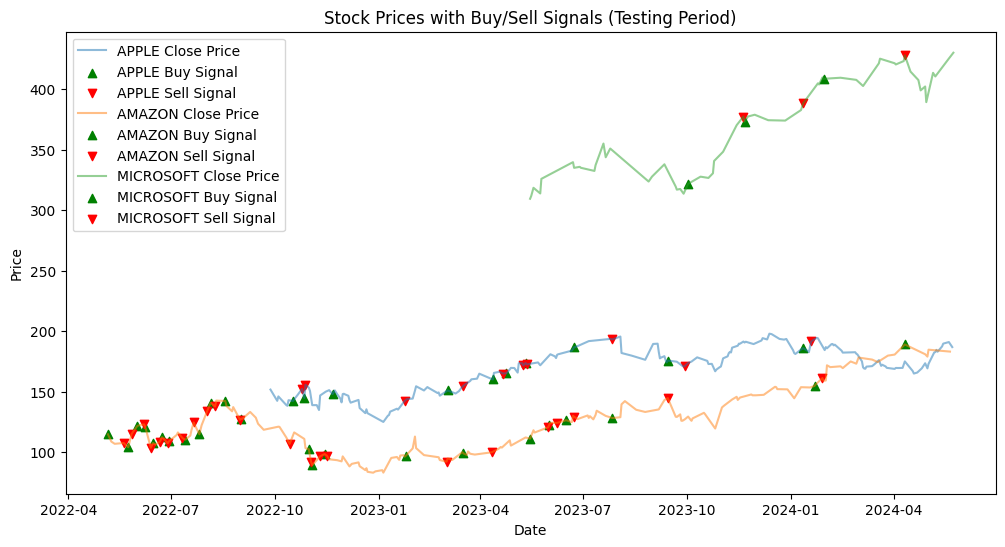

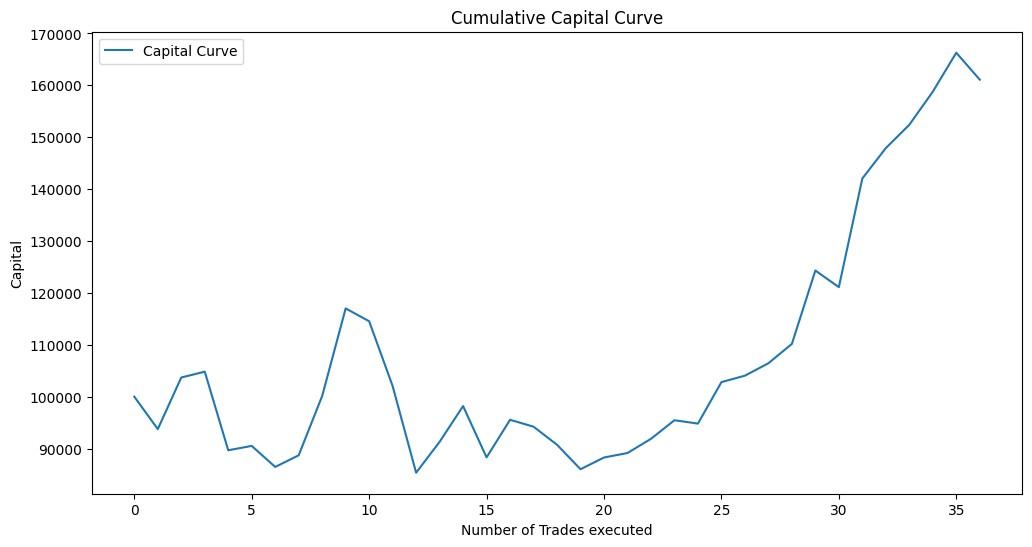

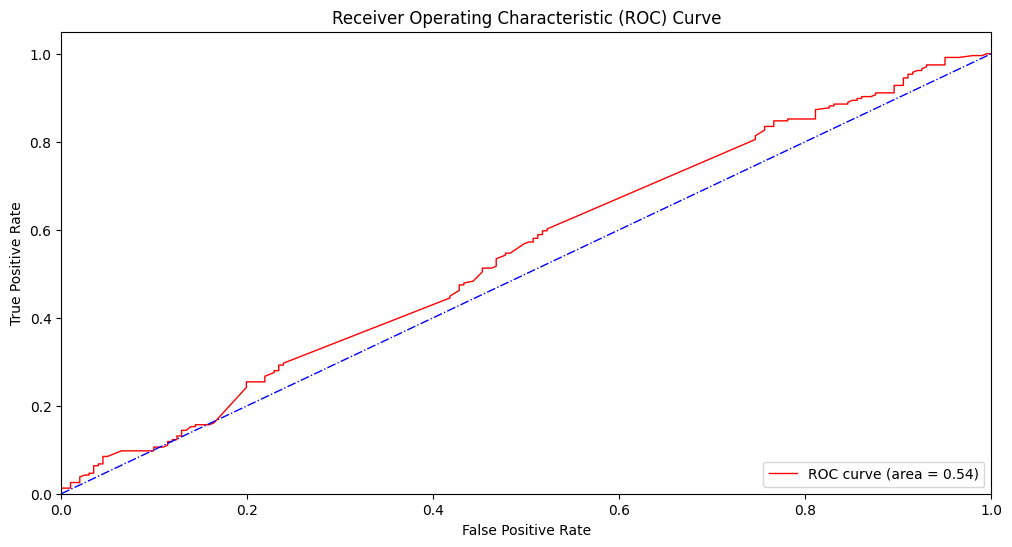

In [19]:
def simulate_trading(stock_data, test_indices, initial_capital):
    capital = initial_capital
    positions = {}
    for stock in stocks:
       positions[stock] = 0


    buy_prices = {}
    for stock in stocks:
        buy_prices[stock] = 0
    num_trades = 0
    num_wins = 0
    returns = []
    capital_curve = [capital]

    # To create a combined dataframe for all stocks
    dfs=[]
    for stock in stocks:
        dfs.append(stock_data[stock])
    combined_df=pd.concat(dfs)
    combined_df=combined_df.sort_values('Date')

    combined_df = combined_df[combined_df.index.isin(np.concatenate(list(test_indices.values())))]

    for index, row in combined_df.iterrows():
        stock = row['Stock']
        if row['Predicted Movement'] == 1:  # buy signal
            if positions[stock] == 0 and capital > 0 and row['Close']!=0:
                positions[stock] = capital / row['Close']
                buy_prices[stock] = row['Close']
                capital = 0
                num_trades += 1
                stock_data[stock].at[index, 'Action'] = 'Buy'
        elif row['Predicted Movement'] == 0:  # Sell signal
            if positions[stock] > 0:
                capital = positions[stock] * row['Close']  # Sell all shares
                profit = capital - (positions[stock] * buy_prices[stock])
                returns.append(profit / (positions[stock] * buy_prices[stock]))
                capital_curve.append(capital)
                if row['Close'] > buy_prices[stock]:
                    num_wins += 1
                positions[stock] = 0
                stock_data[stock].at[index, 'Action'] = 'Sell'

    #To calculate the final capital
    for stock in stocks:
        if positions[stock] > 0:
            capital =capital+ positions[stock] * stock_data[stock].iloc[-1]['Close']
            positions[stock] = 0

    capital_curve.append(capital)

    return stock_data, capital_curve, returns

# Simulate trading for the combined portfolio
initial_capital = 100000
total_capital = 100000

all_true_labels = []
all_pred_probs = []
all_returns = []
all_capital_curves = []
all_predictions = []

stock_data, capital_curve, returns = simulate_trading(stock_data, test_indices, initial_capital)
total_capital =total_capital+ capital_curve[-1] - initial_capital
all_returns.extend(returns)
all_capital_curves.extend(capital_curve)

for stock in stocks:
    all_predictions.extend(stock_data[stock].loc[test_indices[stock], 'Predicted Movement'])
    all_true_labels.extend(stock_data[stock].loc[test_indices[stock], target])
    all_pred_probs.extend(stock_data[stock].loc[test_indices[stock], 'Predicted Prob'])




sharpe_ratio = np.mean(all_returns) / np.std(all_returns) * np.sqrt(252)
drawdowns = np.maximum.accumulate(all_capital_curves) - all_capital_curves
max_drawdown = np.max(drawdowns)
num_trades = len(all_returns)
num_wins = sum(np.array(all_returns) > 0)
win_ratio = num_wins / num_trades if num_trades > 0 else 0

# Calculate accuracy, precision, recall, F1-score for the entire portfolio
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions)
recall = recall_score(all_true_labels, all_predictions)
f1 = f1_score(all_true_labels, all_predictions)

# Calculate ROC Curve and AUC for the combined predictions
fpr, tpr, _ = roc_curve(all_true_labels, all_pred_probs)
roc_auc = roc_auc_score(all_true_labels, all_pred_probs)

print('Final Capital:', total_capital)
print('Profit:', total_capital - initial_capital)
print("Profit Percentage:", (total_capital - initial_capital) / initial_capital * 100)
print('Sharpe Ratio:', sharpe_ratio)
print('Maximum Drawdown:',max_drawdown)
print('Number of Trades Executed:',num_trades)
print('Win Ratio:', win_ratio)
print("AUC:", roc_auc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

print(' ')



plt.figure(figsize=(12, 6))
for stock in stocks:
    test_df = stock_data[stock].loc[test_indices[stock]]
    plt.plot(test_df['Date'], test_df['Close'], label=f'{stock} Close Price', alpha=0.5)
    buys = test_df[test_df['Action'] == 'Buy']
    sells = test_df[test_df['Action'] == 'Sell']
    plt.scatter(buys['Date'], buys['Close'], label=f'{stock} Buy Signal', marker='^', color='green', alpha=1)
    plt.scatter(sells['Date'], sells['Close'], label=f'{stock} Sell Signal', marker='v', color='red', alpha=1)
plt.title('Stock Prices with Buy/Sell Signals (Testing Period)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
print(' ')



# Plot Cumulative Capital Curve
plt.figure(figsize=(12, 6))
plt.plot(all_capital_curves, label='Capital Curve')
plt.title('Cumulative Capital Curve')
plt.xlabel('Number of Trades executed')
plt.ylabel('Capital')
plt.legend()
plt.show()

print(' ')

# Plot ROC Curve
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='red', lw=1, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()